In [2]:
#Pytorch imports

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from tqdm import tqdm_notebook

#Package for creating Actionable Counterfactuals

###import dice_ml as dml
###from dice_ml.explainer_interfaces.dice_pytorch import DicePyTorch
###from dice_ml.utils.exception import UserConfigValidationException

# Package for creating Adversarial Examples

###import art

#Package for creating amicable perturbations

#import amicable_pertubations as ap

#Miscellaneous Utilities 

import numpy as np
import scipy.linalg as la
import pandas as pd
import random

from matplotlib import pyplot as plt

import math

import Utils as ut

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Adult Income

Get and seperate data.

In [3]:
adult_income_data = pd.read_csv('data_folder/numerisized_adult_income_data.csv')

In [4]:
names = list(adult_income_data)

In [5]:
adult_training_dataset, adult_testing_dataset, adult_validation_dataset = ut.get_datasets_from_dataframe(adult_income_data)

In [6]:
adult_income_array = adult_income_data.to_numpy()

In [7]:
adult_training_array, adult_testing_array, adult_validation_array = ut.even_triple_split(adult_income_array)

In [8]:
maxes = np.max(adult_income_array,axis = 0)[:-1]
mins = np.min(adult_income_array,axis = 0)[:-1]
bounds = np.vstack((mins,maxes))

In [9]:
low_income = adult_testing_array[np.where(adult_testing_array[:,-1]==0)]
low_income = low_income[:,:-1]

Make and test models

In [10]:
classifier = ut.Basic_fully_connected_Network(27,2).to(device)
classifier.eval()

Basic_fully_connected_Network(
  (layer1): Linear(in_features=27, out_features=60, bias=True)
  (layer2): Linear(in_features=60, out_features=60, bias=True)
  (layer3): Linear(in_features=60, out_features=60, bias=True)
  (layer4): Linear(in_features=60, out_features=2, bias=True)
)

In [11]:
#Train neural net if not already trained
#Training_Accuracy_History, Validation_Accuracy_History, Training_Loss_History, Validation_Loss_History= train_neural_net(classifier, 'adult_classifier.pt', 100, 1000, 64 , adult_training_dataset,adult_validation_dataset,adult_testing_dataset, new_net = True)


In [12]:
classifier.load_state_dict(torch.load('models_folder/adult_classifier.pt'))

<All keys matched successfully>

In [13]:
classifier_for_softening = ut.Basic_fully_connected_Network(27,2)
classifier_for_softening.eval()

Basic_fully_connected_Network(
  (layer1): Linear(in_features=27, out_features=60, bias=True)
  (layer2): Linear(in_features=60, out_features=60, bias=True)
  (layer3): Linear(in_features=60, out_features=60, bias=True)
  (layer4): Linear(in_features=60, out_features=2, bias=True)
)

In [14]:
classifier_for_softening.load_state_dict(torch.load('models_folder/adult_classifier.pt'))

<All keys matched successfully>

In [15]:
soft_classifier = ut.softmaxed_network(classifier_for_softening)

In [16]:
ut.check_net_accuracy(classifier, adult_testing_dataset, 64, verbose = True)

100%|██████████████████████████████████████████| 62/62 [00:00<00:00, 457.74it/s]

Model Accuracy : 80.12108980827448


0.8012108980827447

In [17]:
low_income_estimates = classifier(torch.tensor(low_income).float().to(device)).detach().cpu().numpy()
correctly_classified = low_income_estimates[:,0]>=low_income_estimates[:,1]
certified_low_income = low_income[correctly_classified]

In [18]:
adult_training_difference_data, adult_testing_difference_data, adult_validation_difference_data = ut.get_difference_datasets_from_dataframe(adult_income_data)

In [19]:
verifier = ut.Basic_fully_connected_Network(54,2).to(device)
verifier.eval()

Basic_fully_connected_Network(
  (layer1): Linear(in_features=54, out_features=60, bias=True)
  (layer2): Linear(in_features=60, out_features=60, bias=True)
  (layer3): Linear(in_features=60, out_features=60, bias=True)
  (layer4): Linear(in_features=60, out_features=2, bias=True)
)

In [20]:
verifier.load_state_dict(torch.load('models_folder/adult_verifier.pt'))

<All keys matched successfully>

In [21]:
ut.check_net_accuracy(verifier, adult_testing_difference_data, 64, verbose = True)

100%|██████████████████████████████████████████| 41/41 [00:00<00:00, 389.45it/s]

Model Accuracy : 69.08602150537635


0.6908602150537635

100%|███████████████████████████████████████████| 41/41 [00:00<00:00, 53.94it/s]


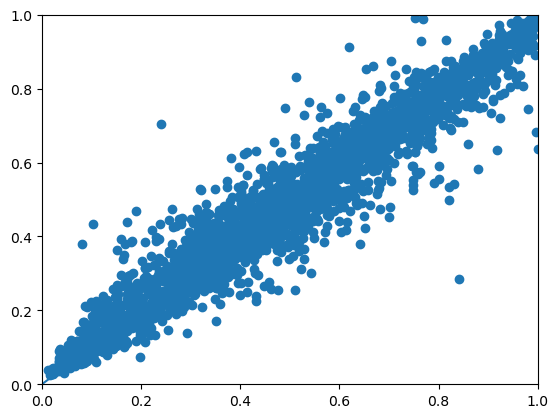

(0.6716589861751152,
 0.67357910906298,
 array([0.46681273, 0.16006333, 0.38324782, ..., 0.24583814, 0.59372264,
        0.75084007]),
 array([0.58988523, 0.39341164, 0.44256812, ..., 0.2917996 , 0.60191673,
        0.76511586]))

In [22]:
ut.check_verifier(verifier,classifier,adult_testing_difference_data, 64)

Define data set dependent functions

In [22]:
def ai_conditioner(x):
    output = x.detach().clone()
    output[0] = torch.round(output[0])
    
    output[1] = torch.round(output[1])
    
    output[2] = torch.round(output[2])
    
    output[3] = torch.round(output[3])
    
    status = torch.argmax(output[4:9])
    output[4:9] *= 0
    output[4+status] += 1
    
    employer = torch.argmax(output[9:13])
    output[9:13] *= 0
    output[9+employer] += 1
    
    education = torch.argmax(output[13:21])
    output[13:21] *= 0
    output[13+education] += 1
    
    job = torch.argmax(output[21:])
    output[21:] *= 0
    output[21+job] += 1
    
    return output

In [23]:
def ai_distance(x,y):
    distance = 0
    distance += 0.1*(y[3]-x[3])**2
    
    status_weights = torch.tensor([[0,2,1000,1000,1000],[100,0,1,1,2],[1000,2,0,1000,1000],[1000,3,2,0,2],[1000,2,1000,1000,0]]).double()    
    distance += torch.dot(torch.mv(status_weights,y[4:9]),x[4:9])
    
    employer_weights  = 1-torch.eye(4).double()
    distance += torch.dot(torch.mv(employer_weights,y[9:13]),x[9:13])
    
    edu_weights = torch.tensor([[0,2,10,3,4,6,8,11],[1000,0,8,1,2,4,6,9],[1000,1000,0,1000,1000,1000,2,5],[1000,1000,7,0,1,3,5,8],[1000,1000,6,1000,0,2,4,7],[1000,1000,4,1000,1000,0,2,5],[1000,1000,4,1000,1000,1000,0,3],[1000,1000,4,1000,1000,1000,1000,0]]).double()
    distance += torch.dot(torch.mv(edu_weights,y[13:21]),x[13:21])
    
    field_weights = torch.tensor([[0,1,2,3,4,1],[1,0,1,2,3,1],[1,1,0,1,2,1],[1,1,1,0,1,1],[1,1,1,1,0,1],[1,1,1,1,1,0]]).double()
    distance += torch.dot(torch.mv(field_weights,y[21:27]),x[21:27])
    
    return distance

In [24]:
def ai_interpretor(x):
    print('Age: '+str(x[0]))
    
    if x[1] == 1:
        print('Race: White')
    else:
        print('Race: Not White')
        
    if x[2] == 1:
        print('Sex: Male')
    else:
        print('Sex: Female')
        
    print('Hours worked per week: '+str(x[3]))
        
    statuses = ['Single','Married','Widowed','Seperated','Divorced']
    status = np.argmax(x[4:9])
    print('Marital Status: '+statuses[status])
    
    
    employers = ['Government','Private', 'Self-Employed', 'Other/Unknown']
    employer = np.argmax(x[9:13])
    print('Employer: '+employers[employer])
    
    educations = ['School','HS-grad','Prof-school','Some-college','Assoc','Bachelors','Masters','Doctorate']
    education = np.argmax(x[13:21])
    print('Education: '+educations[education])
    
    jobs = ['Service','Sales','Blue-Collar','White-Collar','Professional','Other/Unknown_Occupation']
    job = np.argmax(x[21:27])
    print('Occupation: '+jobs[job])

In [25]:
def ai__change_interpretor(x,y):
    age_change =  y[0]-x[0]    
    if age_change > 0:
        print('Age increased by '+str(age_change)+'.')
    elif age_change < 0:
        print('Age decreased by '+str(age_change*-1)+'.')
    
    race_change = y[1]-x[1]
    if race_change ==1:
        print('Changed from non-white to white.')
    elif race_change ==-1:
        print('Changed from white to non-white.')
        
    race_change = y[2]-x[2]
    if race_change ==1:
        print('Changed from female to male.')
    elif race_change ==-1:
        print('Changed from male to female.')
        
    hours_change =  y[3]-x[3]    
    if hours_change > 0:
        print('Hours worked increased by '+str(hours_change)+'.')
    elif hours_change < 0:
        print('Hours worked decreased by '+str(hours_change*-1)+'.')
           
    statuses = ['Single','Married','Widowed','Seperated','Divorced']
    org_status = np.argmax(x[4:9])
    new_status = np.argmax(y[4:9])
    if np.abs(org_status - new_status)>.5:
        print('Marital Status changed from '+statuses[org_status]+' to '+statuses[new_status]+'.')

        
    employers = ['Government','Private', 'Self-Employed', 'Other/Unknown']
    org_employer = np.argmax(x[9:13])
    new_employer = np.argmax(y[9:13])
    if np.abs(org_employer - new_employer)>.5:
        print('Employer type from '+employers[org_employer]+' to '+employers[new_employer]+'.')

        
    educations = ['School','HS-grad','Prof-school','Some-college','Assoc','Bachelors','Masters','Doctorate']
    org_education = np.argmax(x[13:21])
    new_education = np.argmax(y[13:21])
    if np.abs(org_education - new_education)>.5:
        print('Education level changed from '+educations[org_education]+' to '+educations[new_education]+'.')

        
    jobs = ['Service','Sales','Blue-Collar','White-Collar','Professional','Other/Unknown_Occupation']
    org_job = np.argmax(x[21:27])
    new_job = np.argmax(y[21:27])
    if np.abs(org_job - new_job)>.5:
        print('Job type changed from '+jobs[org_job]+' to '+jobs[new_job]+'.')



In [26]:
immutables = torch.tensor([0,1,2,4,5,6,7,8])

In [27]:
categoricals = [(4,8),(9,12),(13,20),(21,26)]

Set up amicable perturbation creator

In [28]:
adult_income_ap_creator = ap.AP_generator_Continuous(classifier.cpu().double(),verifier.cpu().double(),ai_distance,27,2,0.9,None,np.array([1]),np.array([0]),bounds,immutables,ai_conditioner,categoricals,initial_balance_param = 0,categorical_penalty=1,max_iters = 10000,learning_rate = 0.01,bound_penalty = 1)

None


/home/u4/friedbaum/amicable_pertubations.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.immutable = torch.tensor(immutable_indices)


In [29]:
verifier.to(device)

Basic_fully_connected_Network(
  (layer1): Linear(in_features=54, out_features=60, bias=True)
  (layer2): Linear(in_features=60, out_features=60, bias=True)
  (layer3): Linear(in_features=60, out_features=60, bias=True)
  (layer4): Linear(in_features=60, out_features=2, bias=True)
)

In [30]:

aps,probs,deltas,epsilons,ver,discrep = ap.create_pareto_graph(adult_income_ap_creator,classifier,verifier,low_income[0],0,1,21,2000, 1, np.array([]), np.array([]), np.array([]))


Using lambda 0.0


/home/u4/friedbaum/amicable_pertubations.py:607: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  original_probs = torch.nn.functional.softmax(classifier(torch.tensor(x))).detach().cpu().numpy()
/home/u4/friedbaum/amicable_pertubations.py:421: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  original = torch.tensor(x,dtype= float)


Using lambda 0.05
Using lambda 0.1
Using lambda 0.15000000000000002
Using lambda 0.2
Using lambda 0.25
Using lambda 0.30000000000000004
Using lambda 0.35000000000000003
Using lambda 0.4
Using lambda 0.45
Using lambda 0.5
Using lambda 0.55
Using lambda 0.6000000000000001
Using lambda 0.65
Using lambda 0.7000000000000001
Using lambda 0.75
Using lambda 0.8
Using lambda 0.8500000000000001
Using lambda 0.9
Using lambda 0.9500000000000001
Using lambda 1.0


/home/u4/friedbaum/amicable_pertubations.py:639: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  verification = torch.nn.functional.softmax(verifier(torch.tensor(np.concatenate((x,aps[idx]))).to(device).double()))
/home/u4/friedbaum/amicable_pertubations.py:643: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  original_delta = creator.calc_wanted_PD(torch.nn.functional.softmax(classifier(torch.tensor(x))),shrinkage=1).item()


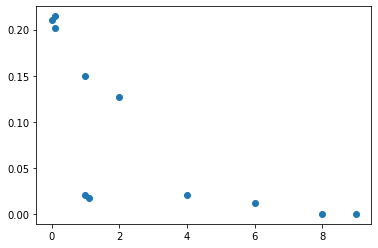

In [31]:
plt.scatter(epsilons,deltas)

Set up Counterfactual creator for comparison

In [32]:
my_dice_data = dml.Data(dataframe=adult_income_data, continuous_features=['age', 'hours_per_week'], outcome_name='income')

In [33]:
soft_classifier.cpu()

softmaxed_network(
  (classifier): Basic_fully_connected_Network(
    (layer1): Linear(in_features=27, out_features=60, bias=True)
    (layer2): Linear(in_features=60, out_features=60, bias=True)
    (layer3): Linear(in_features=60, out_features=60, bias=True)
    (layer4): Linear(in_features=60, out_features=2, bias=True)
  )
  (softener): Softmax(dim=-1)
)

In [34]:
my_dice_model = dml.Model(soft_classifier, backend='PYT')

In [35]:
my_dice_explainer = DicePyTorch(my_dice_data,my_dice_model)

In [36]:
my_variables = [
 'hours_per_week',
 'Government',
 'Private',
 'Self-Employed',
 'Other/Unknown_Work',
 'School',
 'HS-grad',
 'Prof-school',
 'Some-college',
 'Assoc',
 'Bachelors',
 'Masters',
 'Doctorate',
 'Service',
 'Sales',
 'Blue-Collar',
 'White-Collar',
 'Professional',
 'Other/Unknown_Occupation']

In [37]:
my_dice_explainer.generate_counterfactuals(adult_income_data.drop(columns="income")[1:2], total_CFs=1, desired_class="opposite",features_to_vary=my_variables)

100%|██████████| 1/1 [00:03<00:00,  3.29s/it]

Diverse Counterfactuals found! total time taken: 00 min 03 sec


In [38]:
my_categoricals = [[4,5,6,7,8],[9,10,11,12],[13,14,15,16,17,18,19,20],[21,22,23,24,25,26]]

In [39]:
my_dice_explainer.encoded_categorical_feature_indexes = my_categoricals

In [40]:
my_dice_explainer.encoded_continuous_feature_indexes = [0,1,2,3]

In [41]:
my_dice_explainer.cont_minx = [17,0,0,1]

In [42]:
my_dice_explainer.cont_maxx = [90,1,1,99]

In [43]:
my_dice_explainer.minx[0,0] = 17
my_dice_explainer.minx[0,3] = 1

In [44]:
my_dice_explainer.maxx[0,0] = 90
my_dice_explainer.maxx[0,3] = 99

In [45]:
my_dice_explainer.cont_precisions = [0,0,0,0]

In [46]:
my_dice_explainer.feature_weights_list[0] /= 73
my_dice_explainer.feature_weights_list[3] /= 98

In [47]:
soft_classifier.float()

softmaxed_network(
  (classifier): Basic_fully_connected_Network(
    (layer1): Linear(in_features=27, out_features=60, bias=True)
    (layer2): Linear(in_features=60, out_features=60, bias=True)
    (layer3): Linear(in_features=60, out_features=60, bias=True)
    (layer4): Linear(in_features=60, out_features=2, bias=True)
  )
  (softener): Softmax(dim=-1)
)

Test Individual and save results

Using lambda 0.0
Using lambda 0.05
Using lambda 0.1
Using lambda 0.15000000000000002
Using lambda 0.2
Using lambda 0.25
Using lambda 0.30000000000000004
Using lambda 0.35000000000000003
Using lambda 0.4
Using lambda 0.45
Using lambda 0.5
Using lambda 0.55
Using lambda 0.6000000000000001
Using lambda 0.65
Using lambda 0.7000000000000001
Using lambda 0.75
Using lambda 0.8
Using lambda 0.8500000000000001
Using lambda 0.9
Using lambda 0.9500000000000001
Using lambda 1.0


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]
/home/u4/friedbaum/amicable_pertubations.py:211: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction = torch.nn.functional.softmax(self.classifier(torch.tensor(input)),dim = 0)


Diverse Counterfactuals found! total time taken: 00 min 02 sec


100%|██████████| 1/1 [00:15<00:00, 15.80s/it]

Diverse Counterfactuals found! total time taken: 00 min 15 sec
Age: 30.0
Race: White
Sex: Male
Hours worked per week: 50.0
Marital Status: Single
Employer: Private
Education: Bachelors
Occupation: Professional


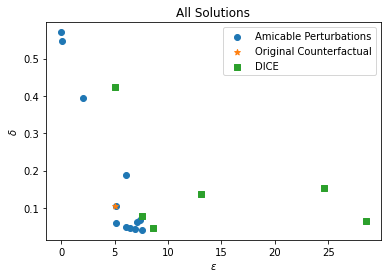

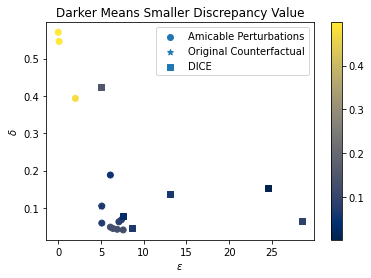

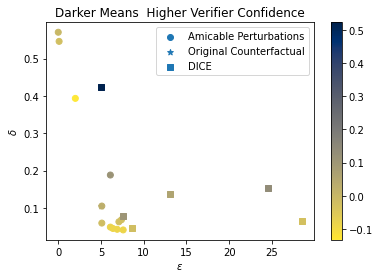

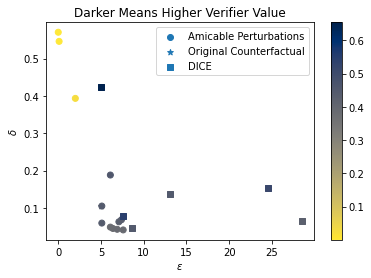


Amicable Perturbations 


Distance to target: 0.1880311369895935
Cost :6.1
Dicrepancy value : 0.052569652883960316
Verification Confidence: 0.11485901208508642
Straight verification value: 0.4567151665687561
Hours worked increased by 1.0.
Employer type from Private to Self-Employed.
Education level changed from Bachelors to Doctorate.

Distance to target: 0.10499143600463867
Cost :5.1
Dicrepancy value : 0.07179035649082621
Verification Confidence: 0.024723525644651467
Straight verification value: 0.4408366084098816
Hours worked increased by 1.0.
Education level changed from Bachelors to Doctorate.

Distance to target: 0.059387341141700745
Cost :5.1
Dicrepancy value : 0.0739477068604728
Verification Confidence: -0.015894249789719483
Straight verification value: 0.4409995675086975
Hours worked increased by 1.0.
Employer type from Private to Self-Employed.
Education level changed from Bachelors to Prof-school.

Distance to target: 0.06286952644586563
Cost :7.1
Dicrepancy value : 0.081589

(array([[ 3.00000000e+01,  1.00000000e+00,  1.00000000e+00,
          5.00000000e+01,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
          0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          4.43591863e-01,  5.56408167e-01,  3.93261611e-01,
          2.00000000e+00,  2.57504731e-02,  4.77232493e-01],
        [ 3.00000000e+01,  1.00000000e+00,  1.00000000e+00,
          5.00000000e+01,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
          0.00000000e+00, -0.00000000e+

In [48]:

ap.test_individual(low_income[4],classifier,soft_classifier,verifier,adult_income_ap_creator,my_dice_explainer,names[:-1],my_variables,immutables,0,1,21,2000,ai_conditioner,ai_distance,ai_interpretor,ai__change_interpretor,6,intersection = 0.51,verbose = True)


In [ ]:

ap.save_results(low_income,2,names[:-1],'adult_income_examples.csv',classifier,soft_classifier,verifier,adult_income_ap_creator,my_dice_explainer,my_variables,immutables,0,1,21,2000,ai_conditioner,ai_distance,ai_interpretor,ai__change_interpretor,6)


# Law School Success

In [ ]:
def ls_interpretor(x):
    
    
    if x[0] == 1:
        print('Sex: Male')
    else:
        print('Sex: Female')
        
    Races = ['Amerindian','Asian','Black','Hispanic','Mexican','Puertorican','White','Other']
    race = np.argmax(x[4:12])
    print('Race: '+Races[race])
        
    print('LAST Score: '+str(x[1]))
    
    print('Undergraduate GPA: '+str(x[2]))
    
    print('First semester grades: '+str(x[3]))
    
    Regions = ['Far West','Great Lakes','Mid-South','Mountain West','Mid-West','North East','New England','North West']
    region = np.argmax(x[12:20])
    print('Region: '+Regions[region])

In [ ]:
def ls_change_interpretor(x,y):
    sex_change =  y[0]-x[0]    
    if sex_change > 0:
        print('Sex changed from female to male.')
    elif sex_change < 0:
        print('Sex changed from male to female.')
        
    Races = ['Amerindian','Asian','Black','Hispanic','Mexican','Puertorican','White','Other']
    original_race = np.argmax(x[4:12])
    new_race = np.argmax(y[4:12])
    if np.abs(original_race - new_race)>.5:
        print('Race changed from '+Races[original_race]+' to '+Races[new_race]+'.')
        
    LSAT_change =  y[1]-x[1]    
    if LSAT_change > 0:
        print('LSAT score increased by '+str(LSAT_change)+'.')
    elif LSAT_change < 0:
        print('LSAT score decreased by '+str(LSAT_change*-1)+'.')
        
    UGPA_change =  y[2]-x[2]    
    if UGPA_change > 0:
        print('Undergraduate GPA increased by '+str(UGPA_change)+'.')
    elif UGPA_change < 0:
        print('Undergraduate GPA decreased by '+str(UGPA_change*-1)+'.')
        
    FSG_change =  y[3]-x[3]    
    if FSG_change > 0:
        print('First Semester Grades increased by '+str(FSG_change)+'.')
    elif FSG_change < 0:
        print('First Semester Grades decreased by '+str(FSG_change*-1)+'.')
    
    Regions = ['Far West','Great Lakes','Mid-South','Mountain West','Mid-West','North East','New England','North West']
    original_region = np.argmax(x[12:20])
    new_region = np.argmax(y[12:20])
    if np.abs(original_region - new_region)>.5:
        print('Region changed from '+Regions[original_region]+' to '+Regions[new_region]+'.')

In [ ]:
def ls_conditioner(invec):
    output = invec.detach().clone()
    output[0] = torch.round(output[0])
    race = torch.argmax(output[4:12])
    output[4:12] *= 0
    output[4+race] += 1
    region = torch.argmax(output[12:20])
    output[12:20] *= 0
    output[12+region] += 1
    return output

In [ ]:
def ls_distance(a,b):
    distance = 0
    distance += b[1]-a[1]
    distance += 10*(b[2]-a[2])
    distance += b[3]-a[3]
    travel_weights = torch.tensor([[0,3,4,1,2,6,5,1],[3,0,1,2,1,2,1,3],[4,1,0,2,1,2,1,5],[1,2,2,0,1,4,3,2],[2,1,1,1,0,3,2,3],[6,2,2,4,3,0,1,5],[5,1,1,3,2,1,0,5],[1,3,5,2,3,5,5,0]]).double()    
    distance += torch.dot(torch.mv(travel_weights,b[12:20]),a[12:20])
    
    return distance

In [ ]:
ls_immutables = np.array([0,1,2,4,5,6,7,8,9,10,11])

In [ ]:
categoricals = [(4,11),(12,19)]

In [ ]:
my_dice_data = dml.Data(dataframe=ls_data, continuous_features=['LSAT', 'UGPA', 'ZFYA'], outcome_name='first_pf')

In [ ]:
soft_classifier.cpu()

In [ ]:
my_dice_model = dml.Model(soft_classifier, backend='PYT')

In [ ]:
my_dice_explainer = DicePyTorch(my_dice_data,my_dice_model)

In [ ]:
my_variables = [
 'ZFYA',
 'FW',
 'GL',
 'MS',
 'Mt',
 'MW',
 'NE',
 'NG',
 'NW']

In [ ]:
my_dice_explainer.generate_counterfactuals(ls_data.drop(columns="first_pf")[1:2], total_CFs=1, desired_class="opposite",features_to_vary=my_variables)

In [ ]:
my_categoricals = [[4,5,6,7,8,9,10,11],[12,13,14,15,16,17,18,19]]


In [ ]:
my_dice_explainer.encoded_categorical_feature_indexes = my_categoricals

In [ ]:
my_dice_explainer.encoded_continuous_feature_indexes = [1,2,3]

In [ ]:
my_dice_explainer.cont_minx = mins[my_dice_explainer.encoded_continuous_feature_indexes]

In [ ]:
my_dice_explainer.cont_maxx = maxes[my_dice_explainer.encoded_continuous_feature_indexes]

In [ ]:
my_dice_explainer.minx[0,my_dice_explainer.encoded_continuous_feature_indexes] = my_dice_explainer.cont_minx = mins[my_dice_explainer.encoded_continuous_feature_indexes]

In [ ]:
my_dice_explainer.maxx[0,my_dice_explainer.encoded_continuous_feature_indexes] = my_dice_explainer.cont_maxx = maxes[my_dice_explainer.encoded_continuous_feature_indexes]

In [ ]:
my_dice_explainer.cont_precisions = [100,100,100]

# Diabetes Prediction

In [ ]:
def torch_dbts_conditioner(x):
    new_x = x.detach().clone()
    new_x = torch.round(new_x)
    return new_x

In [ ]:
def dbts_dist(a,b):
    dist = 0
    dist += 3*(a[0]-b[0])**2
    dist += 3*(a[1]-b[1])**2
    dist += (a[3]-b[3])**2
    dist += (a[7]-b[7])**2
    dist += (a[8]-b[8])**2
    dist += (a[9]-b[9])**2
    dist += (a[10]-b[10])**2
    dist += 4*(a[11]-b[11])**2
    dist += 4*(a[13]-b[13])**2
    dist += 0.25*(a[14]-b[14])**2
    dist += 0.25*(a[15]-b[15])**2
    dist += 5*(a[19]-b[19])**2
    dist += 2*(a[20]-b[20])**2
    return dist

In [ ]:
immutables = torch.tensor([0,1,2,5,6,12,13,14,15,16,17,18])

In [ ]:
categoricals = []

In [ ]:
my_dice_data = dml.Data(dataframe=dbts_data, continuous_features=['BMI', 'GenHlth','MentHlth', 'PhysHlth', 'Age','Education','Income'], outcome_name='Any_Diabetes')

# German Credit

In [ ]:
#For the german credit data we use the Enhanced_fully_connected_Network

In [ ]:
def german_interpretor(x):
    
    print('Loan Duration: '+str(x[0]*deviations[0]+averages[0]))
    
    print('Loan Size: '+str(x[1]*deviations[1]+averages[1]))
    
    print('Disposable Income: '+str(x[2]*deviations[2]+averages[2]))
    
    print('Time at Current Residence: '+str(x[3]*deviations[3]+averages[3]))
    
    print('Age: '+str(x[4]*deviations[4]+averages[4]))
    
    print('Dependents: '+str(x[5]*deviations[5]+averages[5]))
    
    if x[7] == 1:
        print('Telephone: Yes')
    else:
        print('Telephone: No')
    
    if x[8] == 1:
        print('Foreign Worker: Yes')
    else:
        print('Foreign Worker: No')
        
    other_credits = ['Other Credits Critical','Other Credits Critical','All Other Credits Current','Other Credits Delayed','No Other Credits',]
    other_credit = np.argmax(x[9:14])    
    print(other_credits[other_credit])
        
    purposes = ['Appliances','Business','Car(new)','Car(used)','Education','Furniture/Equipment','Other','Radio/TV','Repairs','Retraining']
    purpose = np.argmax(x[14:24])
    print('Purpose: '+purposes[purpose])
    
    
    statuses = ['Female','Divorced Male', 'Married Male', 'Single Male']
    status = np.argmax(x[24:28])
    print('Personal Status: '+statuses[status])
    
    files = ['Co-file','Guarantor','Single-file']
    file = np.argmax(x[28:31])
    print('Filing Type: '+files[file])
    
    collaterals = ['Car','Life Insurance','Real Estate','None']
    collateral = np.argmax(x[31:35])
    print('Collateral: '+collaterals[collateral])
    
    housings = ['Free','Own','Rent']
    housing = np.argmax(x[35:38])
    print('Housing Type: '+housings[housing])
       
    installments = ['Bank','None','Store']
    installment = np.argmax(x[38:41])
    print('Other Installments: '+installments[installment])
    
    checkings = ['Less than 0','Between 0 and 200','Greater than 200', 'No checking account']
    checking = np.argmax(x[41:45])
    print('Amount in Checkings: '+checkings[checking])
    
    savings = ['No savings account','Between 0 and 100','Between 500 and 1,000','Between 100 and 500', 'Greater than 1000']
    saving = np.argmax(x[45:50])
    print('Amount in Savings: '+savings[saving])
    
    employments = ['Less than a year','Between 1 and 4 years','Between 4 and 7 years','Greater than 7 years']
    employment = np.argmax(x[50:54])
    print('Employment length: '+employments[employment])
    
    jobs = ['Unemployed','Managemant','Skilled','Unskilled','Unskilled non-resident']
    job = np.argmax(x[50:55])
    print('Job Type: '+jobs[job])
    
    return    
    

In [ ]:
def german_change_interpretor(x,y):
    
    duration_change =  y[0]-x[0]    
    if duration_change > 0:
        print('Duration increased by '+str(duration_change*deviations[0])+' months.')
    elif duration_change < 0:
        print('Duration decreased by '+str(duration_change*deviations[0])+' months.')
    
    size_change =  y[1]-x[1]    
    if size_change > 0:
        print('Size increased by '+str(size_change*deviations[1])+' DM.')
    elif size_change < 0:
        print('Size decreased by '+str(size_change*deviations[1])+' DM.')
        
    income_change =  y[2]-x[2]    
    if income_change > 0:
        print('Income increased by '+str(income_change*deviations[2])+'.')
    elif income_change < 0:
        print('Income decreased by '+str(income_change*deviations[2])+'.')
        
    residence_change =  y[3]-x[3]    
    if residence_change > 0:
        print('Time at residence increased by '+str(residence_change*deviations[3])+' years.')
    elif residence_change < 0:
        print('Time at residence decreased by '+str(residence_change*deviations[4])+' years.')
        
    age_change =  y[4]-x[4]    
    if age_change > 0:
        print('Age increased by '+str(age_change*deviations[4])+' years.')
    elif age_change < 0:
        print('Age decreased by '+str(age_change*deviations[4])+' years.')
        
    credits_change =  y[5]-x[5]    
    if credits_change > 0:
        print('Existing credits increased by '+str(credits_change*deviations[5])+'.')
    elif credits_change < 0:
        print('Existing credits decreased by '+str(credits_change*deviations[5])+'.')
        
    dependents_change =  y[6]-x[6]    
    if dependents_change > 0:
        print('Dependents increased by '+str(dependents_change*deviations[6])+'.')
    elif dependents_change < 0:
        print('Dependents decreased by '+str(dependents_change*deviations[6])+'.')
    
    telephone_change = y[7]-x[7]
    if telephone_change ==1:
        print('Got Telephone.')
    elif telephone_change ==-1:
        print('Lost Telephone.')
        
    other_credits = ['Other Credits Critical','Other Credits Critical','All Other Credits Current','Other Credits Delayed','No Other Credits',]
    org_other_credit = np.argmax(x[9:14])    
    new_other_credit = np.argmax(y[9:14]) 
    if np.abs(org_other_credit - new_other_credit)>.5:
        print('Other Credits changed from '+other_credits[org_other_credit]+' to '+other_credits[new_other_credit]+'.')
        
    purposes = ['Appliances','Business','Car(new)','Car(used)','Education','Furniture/Equipment','Other','Radio/TV','Repairs','Retraining']
    org_purpose = np.argmax(x[14:24])
    new_purpose = np.argmax(y[14:24])
    if np.abs(org_purpose - new_purpose)>.5:
        print('Marital Status changed from '+purposes[org_purpose]+' to '+purposes[new_purpose]+'.')
    
    
    statuses = ['Female','Divorced Male', 'Married Male', 'Single Male']
    org_status = np.argmax(x[24:28])
    new_status = np.argmax(y[24:28])
    if np.abs(org_status - new_status)>.5:
        print('Marital Status changed from '+statuses[org_status]+' to '+statuses[new_status]+'.')
    
    files = ['Co-file','Guarantor','Single-file']
    org_file = np.argmax(x[28:31])
    new_file = np.argmax(y[28:31])
    if np.abs(org_file - new_file)>.5:
        print('Filing type changed from '+files[org_file]+' to '+files[new_file]+'.')
    
    collaterals = ['Car','Life Insurance','Real Estate','None']
    org_collateral = np.argmax(x[31:35])
    new_collateral = np.argmax(y[31:35])
    if np.abs(org_collateral - new_collateral)>.5:
        print('Collateral type changed from '+collaterals[org_collateral]+' to '+collaterals[new_collateral]+'.')
    
    housings = ['Free','Own','Rent']
    org_housing = np.argmax(x[35:38])
    new_housing = np.argmax(y[35:38])
    if np.abs(org_housing - new_housing)>.5:
        print('Housing type changed from '+housings[org_housing]+' to '+housings[new_housing]+'.')
       
    installments = ['Bank','None','Store']
    org_installment = np.argmax(x[38:41])
    new_installment = np.argmax(y[38:41])
    if np.abs(org_installment - new_installment)>.5:
        print('Installment type changed from '+installments[org_installment]+' to '+installments[new_installment]+'.')
    
    checkings = ['Less than 0','Between 0 and 200','Greater than 200', 'No checking account']
    org_checking = np.argmax(x[41:45])
    new_checking = np.argmax(y[41:45])
    if np.abs(org_checking - new_checking)>.5:
        print('Checking account changed from '+checkings[org_checking]+' to '+checkings[new_checking]+'.')
    
    savings = ['No savings account','Between 0 and 100','Between 500 and 1,000','Between 100 and 500', 'Greater than 1000']
    org_saving = np.argmax(x[45:50])
    new_saving = np.argmax(y[45:50])
    if np.abs(org_saving - new_saving)>.5:
        print('Saving account changed from '+savings[org_saving]+' to '+savings[new_saving]+'.')
    
    employments = ['Less than a year','Between 1 and 4 years','Between 4 and 7 years','Greater than 7 years']
    org_employment = np.argmax(x[50:54])
    new_employment = np.argmax(y[50:54])
    if np.abs(org_employment - new_employment)>.5:
        print('Time at employment changed from '+employments[org_employment]+' to '+employments[new_employment]+'.')
    
    jobs = ['Unemployed','Managemant','Skilled','Unskilled','Unskilled non-resident']
    org_job = np.argmax(x[50:55])
    new_job = np.argmax(x[50:55])
    if np.abs(org_job - new_job)>.5:
        print('Job type changed from '+jobs[org_job]+' to '+jobs[new_job]+'.')

    return

In [ ]:
def german_conditioner(x):

    new_x = x.detach().clone()  
    
    true_duration = torch.round((new_x[0]*deviations[0])+averages[0])
    new_x[0] = (true_duration-averages[0])/deviations[0]
    
    true_size = torch.round(new_x[1]*deviations[1]+averages[1])
    new_x[1] = (true_size-averages[1])/deviations[1]
    
    new_x[7:9] = torch.round(x[7:9])
    
    credit_state= torch.argmax(new_x[9:14])
    new_x[9:14] *= 0
    new_x[9+credit_state] += 1
    
    purpose = torch.argmax(new_x[14:24])
    new_x[14:24] *= 0
    new_x[14+purpose] += 1
    
    personal = torch.argmax(new_x[24:28])
    new_x[24:28] *= 0
    new_x[24+personal] += 1
    
    file = torch.argmax(new_x[28:31])
    new_x[28:31] *= 0
    new_x[28+file] += 1
    
    collateral = torch.argmax(new_x[31:35])
    new_x[31:35] *= 0
    new_x[31+collateral] += 1
       
    housing = torch.argmax(new_x[35:38])
    new_x[35:38] *= 0
    new_x[35+housing] += 1
    
    installments = torch.argmax(new_x[38:41])
    new_x[38:40] *= 0
    new_x[38+installments] += 1
    
    checking = torch.argmax(new_x[41:45])
    new_x[41:45] *= 0
    new_x[41+checking] += 1
    
    savings = torch.argmax(new_x[45:50])
    new_x[45:50] *= 0
    new_x[45+savings] += 1
    
    employment = torch.argmax(new_x[50:55])
    new_x[50:55] *= 0
    new_x[50+employment] += 1
    
    job = torch.argmax(new_x[55:59])
    new_x[55:59] *= 0
    new_x[55+job] += 1
    
    new_x = torch.min(new_x,torch.tensor(maxes))
    new_x = torch.max(new_x,torch.tensor(mins))
    

    
    return new_x

In [ ]:
def german_dist(a,b):
    distance = 0
    
    distance += torch.abs((b[0]-a[0])*deviations[0])*(a[2]*deviations[2]+averages[2])/12
    
    distance += torch.abs((a[1]-b[1])*deviations[1])
    
    distance += (b[7]-a[7])*50
    
    
    checking_matrix = torch.tensor([[0,200,400,200],[-200,0,200,0],[-400,-200,0,-200],[-200,0,200,0]]).double()    
    distance += torch.dot(torch.mv(checking_matrix,b[41:45]),a[41:45])
    
    savings_matrix = torch.tensor([[0,0,500,100,1000],[0,0,500,100,1000],[-500,-500,0,-400,500],[-100,-100,-400,0,500],[-1000,-1000,-500,-900,0]]).double()    
    distance += torch.dot(torch.mv(savings_matrix,b[45:50]),a[45:50])
    
    
    
    return distance

In [ ]:
immutables = torch.tensor([2,3,4,5,6,]+[i for i in range(8,40)]+[i for i in range(50,59)])

In [ ]:
categoricals = [(9,13),(14,23),(24,27),(28,30),(31,34),(35,37),(38,40),(41,44),(45,49),(50,53),(54,58)]

In [ ]:
my_dice_model = dml.Model(soft_classifier, backend='PYT')

In [ ]:
my_dice_explainer = DicePyTorch(my_dice_data,my_dice_model)

In [ ]:
immutables

In [ ]:
my_variables = [
 'Duration',
 'Loan_Size',
 'Telephone',
 'Checking < 0 DM',
 'Checking < 200 DM',
 'Checking > 200 DM',
 'No checking',
 'No checking',
 'Savings < 100 DM',
 'Savings < 1000 DM',
 'Savings < 500 DM'
 'Savings > 1000 DM']

In [ ]:
my_dice_explainer.generate_counterfactuals(all_dataframe.drop(columns="Good_Risk")[1:2], total_CFs=1, desired_class="opposite",features_to_vary=my_variables)

In [ ]:
my_categoricals = [(9,10,11,12,13),(14,15,16,17,18,19,20,21,22,23),(24,25,26,27),(28,29,30),(31,32,33,34),(35,36,37),(38,39,40),(41,42,43,44),(46,47,48,49),(50,51,52,53),(54,55,56,57,58)]

In [ ]:
my_dice_explainer.encoded_categorical_feature_indexes = my_categoricals

In [ ]:
my_dice_explainer.encoded_continuous_feature_indexes = np.arange(9)

In [ ]:
my_dice_explainer.cont_minx  = mins[:9]

In [ ]:
my_dice_explainer.cont_maxx = maxes[:9]

In [ ]:
my_dice_explainer.minx[0] = mins

In [ ]:
my_dice_explainer.maxx[0] = maxes

In [ ]:
my_dice_explainer.cont_precisions = np.ones(9,dtype = int)

In [ ]:
my_dice_explainer.feature_weights_list /= maxes-mins